# Slither Link (数回)

Slither Link (also known as Fences and Loop the Loop) is a logic puzzle with simple rules and challenging solutions.

The rules are simple. You have to draw lines between the dots to form a single loop without crossings or branches.

----------

游戏规则很简单。 游戏目标是画线连接棋盘上的点形成一条唯一的回路，所画的线不能出现交叉或分枝的情况。 只能在四方向相邻的节点之间连接。

⚠️： Ortools CS-SAT solver doesn't support Callback function to add Lazy Cut constraint. Instead, the MILP formulation is used and solved via Gurobi.


<https://www.puzzles.wiki/wiki/Slitherlink>

<https://wpcunofficial.miraheze.org/wiki/Main_Page>

Puzzles and Games: A Mathematical Modeling Approach. Tony Hürlimann, 2015 



In [7]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb
import numpy as np
import os
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle

In [8]:
def readInstance(path):
    
    # 从测试案例中随机选取一个测试案例出来
    file_name = f"../assets/data/slitherlinkdata/{path}{np.random.randint(6)+1}.txt"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        # keys = ['m', 'n', 'w', 'p']
        # d = dict()
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[-1 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                
                for j in range(n):
                    if line[j] != '.':
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    data = "30x25normal"
    m, n, grids = readInstance(data)
    print(grids)

READING FILE ../assets/data/slitherlinkdata/30x25normal1.txt
[[3, 3, -1, 2, -1, 2, -1, -1, -1, 3, -1, -1, 2, -1, -1, 2, 1, 2, -1, 2, -1, -1, -1, -1, -1], [1, -1, -1, -1, -1, 1, -1, 2, -1, -1, 1, -1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1, 1, 2, 2], [-1, 2, -1, -1, 2, 3, 3, -1, -1, -1, -1, 2, 2, 2, 1, -1, -1, -1, 2, -1, 1, 3, 2, -1, 2], [-1, 3, 3, -1, 1, -1, 1, -1, 2, 1, -1, -1, -1, -1, 1, 2, 2, 2, 2, -1, 2, -1, -1, 1, 3], [2, 1, 1, 2, 2, 2, 3, 2, -1, -1, 1, 1, 2, 2, 1, 1, 3, 2, -1, -1, -1, 2, 3, -1, -1], [2, -1, -1, -1, -1, 1, -1, 1, 2, 2, 1, -1, -1, -1, 3, -1, -1, -1, -1, 2, -1, -1, 2, 1, -1], [2, -1, -1, 3, 2, 1, 2, 2, -1, -1, -1, -1, 0, -1, 2, -1, 2, -1, 2, -1, -1, -1, 2, -1, -1], [-1, -1, 2, -1, -1, -1, -1, -1, 3, 2, -1, -1, -1, -1, 2, -1, 3, 1, 1, 2, 1, 2, 1, -1, 2], [-1, 2, 3, -1, 2, 0, 2, 0, -1, 1, 0, 2, -1, -1, 3, -1, 2, -1, 3, 2, -1, 3, -1, 2, -1], [-1, 1, 1, -1, -1, 2, -1, 2, 3, 2, 1, 3, 0, -1, 0, 3, -1, -1, 2, 2, -1, 2, -1, 2, -1], [-1, -1, 2, -1, -1, -1, 2, -1, -1, -1, -1, 3,

In [9]:
def Node2Corners(m, n, i, j):
    upperLeft = (n + 1) * i + j
    return [
        (upperLeft, upperLeft + 1),
        (upperLeft + 1, upperLeft + n + 2),
        (upperLeft + n + 2, upperLeft + n + 1),
        (upperLeft + n + 1, upperLeft),
        (upperLeft + 1, upperLeft),
        (upperLeft + n + 2, upperLeft + 1),
        (upperLeft + n + 1, upperLeft + n + 2),
        (upperLeft, upperLeft + n + 1)
    ]

def SlitherlinkwithLazyCuts(m, n, grids) :
    """_summary_

    Args:
        m (_type_): 行数
        n (_type_): 列数
    """
    
    Slitherlink = grb.Model("SlitherLink")
    x = {}
    nodes_num = (m + 1) * (n + 1)
    to_dict = {}
    
    # 按照下标对节点进行表示
    # 节点的数量
    
    for i in range(nodes_num):
        # 首先确定4个点
        if i == 0:
            to_dict[i] = [i + 1, i + n + 1]
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        elif i == n:
            to_dict[i] = [i - 1, i + n + 1]
            
            
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        elif i == m * (n + 1):
            to_dict[i] = [i - n - 1, i + 1]
            
            
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
        elif i == m * n + m + n:
            to_dict[i] = [i - 1, i - n -1]
            
            
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
        elif i < n:
            # 上
            to_dict[i] = [i - 1, i + 1, i + n + 1]
            
            
            
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        elif i > m * (n + 1) :
            to_dict[i] = [i - 1, i + 1, i - n - 1]
            # 下
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
        elif i % (n + 1) == 0:
            # 左侧栏
            to_dict[i] = [i - n - 1, i + 1, i + n + 1]
            
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        elif i % (n + 1) == n:
            # 右侧栏
            to_dict[i] = [i - n - 1, i - 1, i + n + 1]
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        else:
            # 可以在四个方向上连接的情况
            to_dict[i] = [i - n - 1, i - 1, i + 1, i + n + 1]
            x[i, i - n - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - n - 1}]"
            )
            x[i, i - 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i - 1}]"
            )
            x[i, i + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + 1}]"
            )
            x[i, i + n + 1] = Slitherlink.addVar(
                vtype = grb.GRB.BINARY,
                obj = 1,
                name = f"x[{i},{i + n + 1}]"
            )
        
    print(f"All lines (After double) {len(x)}")
    Slitherlink.modelSense = grb.GRB.MINIMIZE
    Slitherlink.Params.lazyConstraints = 1
    Slitherlink.update()
    
    
    for i in range(nodes_num):
        # 流平衡约束（由于并不一定要访问所有的节点，所以这里不需要强制为1，相较于TSP要做一个松弛）
        Slitherlink.addConstr(grb.quicksum(x[i, j] for j in to_dict[i]) == grb.quicksum(x[j, i] for j in to_dict[i]), name = f"Balance_Node_{i}")
        Slitherlink.addConstr(grb.quicksum(x[i, j] for j in to_dict[i]) <= 1, name = f"Balance_Node_{i}_not_greater_than1")
        for target in to_dict[i]:
            if target > i:
                Slitherlink.addConstr(x[i, target] + x[target, i] <= 1, name = f"ChooseOne{i}_{target}")
    
    for i in range(len(grids)):
        for j in range(len(grids[0])):
            if grids[i][j] >= 0 and grids[i][j] < 4:
                Slitherlink.addConstr(grb.quicksum(x[xx, yy] for (xx, yy) in Node2Corners(m, n, i, j)) == grids[i][j], name = f"#ofnode_{i}_{j}")
    
    def subtourelim(model, where):
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # print("Add Cut Here!")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component for j in component if j in to_dict[i]) <= len(component) - 1)
                    
    Slitherlink._x = x
    Slitherlink.optimize(subtourelim)
    # Slitherlink.optimize()
    # Slitherlink.write("Slitherlink.lp")

    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (Slitherlink.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = Slitherlink.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        # assert len(arcs) == len(nodes_pos) - 1
        # currentNode = nodeIDs[0]
        # seq.append(currentNode)
        # while (len(arcs) > 0):
        #     for i in range(len(arcs)):
        #         if (arcs[i][0] == currentNode):
        #             currentNode = arcs[i][1]
        #             seq.append(currentNode)
        #             arcs.pop(i)
        #             break
        gap = 0
        lb = ofv
        ub = ofv
        runtime = Slitherlink.Runtime
    elif (Slitherlink.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = Slitherlink.MIPGap
        lb = Slitherlink.ObjBoundC
        ub = Slitherlink.ObjVal
        runtime = Slitherlink.Runtime


    
    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }
    
    
if __name__ == "__main__":
    result = SlitherlinkwithLazyCuts(m, n, grids)
    print(result)

All lines (After double) 3110
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3524 rows, 3110 columns and 15296 nonzeros
Model fingerprint: 0xf489037f
Variable types: 0 continuous, 3110 integer (3110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 618 rows and 283 columns
Presolve time: 0.03s
Presolved: 2906 rows, 2827 columns, 12984 nonzeros
Variable types: 0 continuous, 2827 integer (2827 binary)

Root relaxation: objective 4.810000e+02, 1587 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  481.00000    0  900      

In [10]:
def coordinatesParser(m, n, idx):
    """_summary_
        进行坐标转换 
    Args:
        m (_type_): _description_
        n (_type_): _description_
        idx (_type_): _description_

    Returns:
        _type_: _description_
    """
    ori_x , ori_y = idx // n, idx % n 
    return (0.5 + ori_y, 0.5 + ( m - ori_x - 1) )

def coordinatesParserNodes(m, n, idx):
    ori_x, ori_y = idx // (n + 1), idx % (n + 1)
    return (ori_y, m - ori_x )


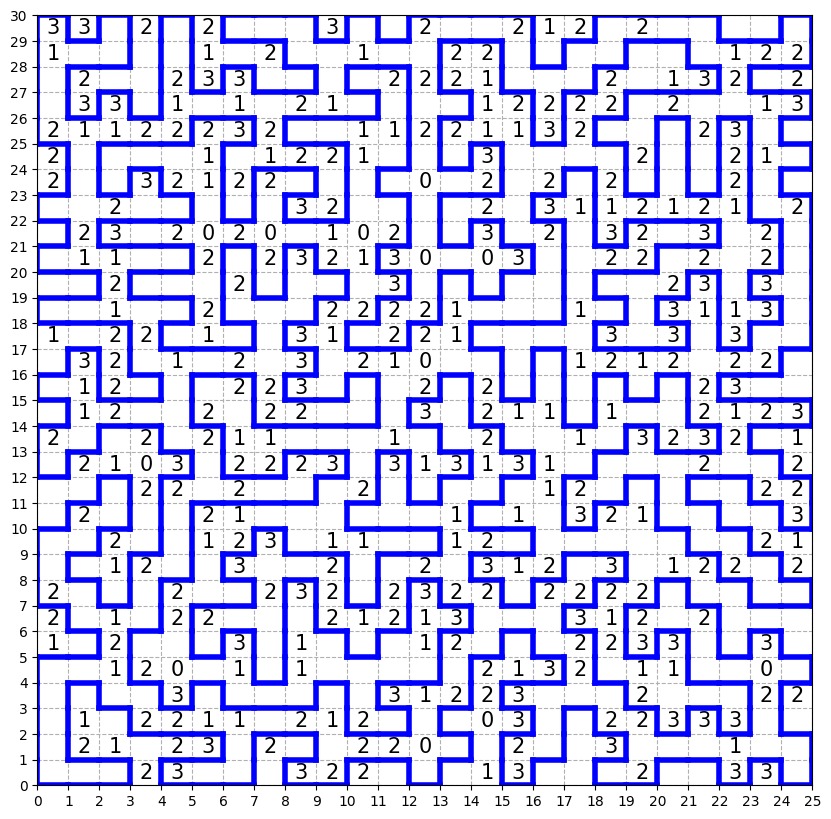

In [11]:
# Visualize 2 b done
def Vis(m, n, grid, result):
    plt.figure(figsize=(10,10))

    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    # 把x/y轴的主刻度设置为1的倍数
    ax.yaxis.set_major_locator(y_major_locator)

    plt.xlim(0,n)
    plt.ylim(0,m)

    plt.grid(linestyle = "--")

    # 绘制无法被访问的方块
    for i in range(m):
        for j in range(n):
            if grids[i][j] != -1:    
                new_coor = coordinatesParser(m, n, i * n + j)
                ax.text(new_coor[0], new_coor[1], str(grids[i][j]), 
                        horizontalalignment = "center", 
                        verticalalignment = 'center',
                        fontsize = 15)

    # 绘制结果连线
    for line in result["arcs"]:
        dot1 = coordinatesParserNodes(m, n, line[0])
        dot2 = coordinatesParserNodes(m, n, line[1])
        plt.plot([dot1[0], dot2[0]], [dot1[1], dot2[1]], linestyle="-", linewidth = 4, color = "blue") 

    plt.show()

if __name__ == "__main__":
    Vis(m, n, grids, result)

## Using CS-SAT solver of Ortools 

- Not suitable for larger grid

In [73]:


import time
# import pycosat
import multiprocessing
from ortools.sat.python import cp_model as cp


class CheckGridFeasible(object):
    def __init__(self, width, height ) -> None:
        self.width = width
        self.height = height
    
    def get_corner_vertexes(self, vertex_id):
        col = vertex_id % (self.width + 1)
        row = vertex_id // (self.width + 1)
        upper_edge = None
        lower_edge = None
        left_edge = None
        right_edge = None
        distance = self.width * (self.height + 1)
        if row > 0:
            upper_edge = distance + vertex_id - (self.width + 1)
        if row < self.height:
            lower_edge = distance + vertex_id
        if col > 0:
            left_edge = (self.width * row) + col - 1
        if col < self.width:
            right_edge = (self.width * row) + col
        vertexes = [vertex for vertex in [upper_edge, lower_edge, left_edge, right_edge]
                    if vertex is not None]
        return vertexes

    def get_adjacent_edges(self, edge_id):
        num_vertexes = (self.width + 1) * (self.height + 1)
        v1, v2 = [vertex_id for vertex_id in range(num_vertexes)
                  if edge_id in self.get_corner_vertexes(vertex_id)]
        edge1 = [edge for edge in self.get_corner_vertexes(v1)
                 if edge != edge_id]
        edge2 = [edge for edge in self.get_corner_vertexes(v2)
                 if edge != edge_id]
        return edge1 + edge2
    
    def is_one_loop(self, solution):
        if solution is []:
            return False
        # print("UNDER CHECK")
        solution = [edge - 1 for edge in solution]
        far_edges = solution[1:]
        start = [solution[0]]
        # Implement Fill Algorithm
        while far_edges != []:
            lines = [line for edge in start
                     for line in self.get_adjacent_edges(edge)
                     if line in far_edges]
            if lines == [] and far_edges != []:
                return False
            far_edges = [edge for edge in far_edges if edge not in lines]
            start = lines
        
        # self.model.solver().FinishCurrentSearch()
        return True

class VarArraySolutionCollector(cp.CpSolverSolutionCallback):
    def __init__(self, variables, width, height, cells):
        cp.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.solution_list = []
        self.width = width
        self.height = height
        self.cells = cells
        self.solution = []
        
        # self.model = model

    def on_solution_callback(self):
        self.__solution_count += 1
        self.solution_list.append([self.Value(v) for v in self.__variables])
        test_solution = [idx + 1 for idx, val in enumerate(self.__variables) if self.Value(val) == 1]
        cgf = CheckGridFeasible(self.width, self.height)
        if cgf.is_one_loop(test_solution):
            # print("FOUND ONE")
            self.solution = test_solution
            self.draw_solution()
            # self.model.solver().Finish
        else:
            print(f"# of Solution: {self.__solution_count}")
            
    def draw_solution(self):
        num_row = 4 * (self.height + 1) + 1
        num_col = 4 * (self.width + 1) + 1
        g = [[' ' for cols in range(num_col)] for rows in range(num_row)]

        def horizontal_edge(edge):
            col_f = edge % self.width
            row_l = edge // self.width
            y = 4 * row_l
            x1 = 4 * col_f
            x2 = 4 * (col_f + 1)
            for x in range(x1, x2 + 1):
                g[y][x] = '#'

        def vertical_edge(edge):
            row_f = edge // (self.width + 1)
            col_l = edge % (self.width + 1)
            y1 = 4 * row_f
            y2 = 4 * (row_f + 1)
            x = 4 * col_l
            for y in range(y1, y2 + 1):
                g[y][x] = '#'

        def draw_numbers():
            for row_index, row in enumerate(self.cells):
                for col_index, val in enumerate(row):
                    if val is not None:
                        y = 4 * row_index + 2
                        x = 4 * col_index + 2
                        g[y][x] = str(val)

        draw_numbers()
        horizontal_limit = self.height * (self.width + 1)
        horizontals = [e - 1
                       for e in self.solution
                       if e <= horizontal_limit]
        verticals = [e - horizontal_limit - 1
                     for e in self.solution
                     if e > horizontal_limit]
        for h_edge in horizontals:
            horizontal_edge(edge=h_edge)
        for v_edge in verticals:
            vertical_edge(edge=v_edge)
        gs = '\n'.join([''.join(g_row) for g_row in g])
        print(gs)

class Slitherlink(object):

    # Definition of some important variables
    def __init__(self):
        self.cells = None
        self.width = None
        self.height = None
        self.cell_constraints = []
        self.loop_constraints = []
        # self.model = cp.CpModel()
        # self.solver = cp.CpSolver()
        # self.variables = []
        
    """"
     TODO
     Rewrite read problem function 
    """



    def read_problem(self, filename):
        self.cells = []
        with open(filename) as fin:
            firstline = fin.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            self.width = n
            self.height = m
            for idx in range(m):
                line = fin.readline().strip().split(" ")
                self.cells.append([None if char == '.' else int(char)
                            for char in line])

        

    def get_cell_edges(self, cell_id):
        # Define the position of a cell by its id
        cell_row = cell_id // self.width
        cell_col = cell_id % self.width
        num_horizontal = self.height * (self.width + 1)
        # Return four integers
        upper_edge = cell_id
        lower_edge = upper_edge + self.width
        left_edge = num_horizontal + ((cell_row * (self.width + 1)) + cell_col)
        right_edge = left_edge + 1
        return [upper_edge, lower_edge, left_edge, right_edge]

    def get_corner_vertexes(self, vertex_id):
        col = vertex_id % (self.width + 1)
        row = vertex_id // (self.width + 1)
        upper_edge = None
        lower_edge = None
        left_edge = None
        right_edge = None
        distance = self.width * (self.height + 1)
        if row > 0:
            upper_edge = distance + vertex_id - (self.width + 1)
        if row < self.height:
            lower_edge = distance + vertex_id
        if col > 0:
            left_edge = (self.width * row) + col - 1
        if col < self.width:
            right_edge = (self.width * row) + col
        vertexes = [vertex for vertex in [upper_edge, lower_edge, left_edge, right_edge]
                    if vertex is not None]
        return vertexes

    def get_adjacent_edges(self, edge_id):
        num_vertexes = (self.width + 1) * (self.height + 1)
        v1, v2 = [vertex_id for vertex_id in range(num_vertexes)
                  if edge_id in self.get_corner_vertexes(vertex_id)]
        edge1 = [edge for edge in self.get_corner_vertexes(v1)
                 if edge != edge_id]
        edge2 = [edge for edge in self.get_corner_vertexes(v2)
                 if edge != edge_id]
        return edge1 + edge2

    def generate_cell_constraints(self):

        # If the value of the cell is 0
        def zero(e1, e2, e3, e4):
            return [[-e1], [-e2], [-e3], [-e4]]

        # If the value of the cell is 1
        def one(e1, e2, e3, e4):
            return [[e1, e2, e3, e4], [-e1, -e2], [-e1, -e3], [-e1, -e4],
                    [-e2, -e3], [-e2, -e4], [-e3, -e4]]

        # If the value of the cell is 2
        def two(e1, e2, e3, e4):
            return [[e2, e3, e4], [e1, e3, e4],
                    [e1, e2, e4], [e1, e2, e3],
                    [-e2, -e3, -e4], [-e1, -e3, -e4],
                    [-e1, -e2, -e4], [-e1, -e2, -e3]]

        # If the value of the cell is 3
        def three(e1, e2, e3, e4):
            return [[e1, e2], [e1, e3], [e1, e4],
                    [e2, e3], [e2, e4], [e3, e4],
                    [-e1, -e2, -e3, -e4]]

        self.cell_constraints = []
        # Base value of cell_id
        cell_id = -1
        list_value = [zero, one, two, three]
        # TODO here
        for row in range(self.height):
            for col in range(self.width):
                cell_id += 1
                cell_value = self.cells[row][col]
                if cell_value is None:
                    pass
                else:
                    edges = [1 + e for e in self.get_cell_edges(cell_id)]
                    clause = list_value[cell_value](*edges)
                    # print(clause)
                    self.cell_constraints += clause

    def generate_loop_constraints(self):

        # Number of correct edges if a vertex is in the corner
        def two(e1, e2):
            return [[-e1, e2], [e1, -e2]]

        # Number of correct edges if a vertex is in the edge
        def three(e1, e2, e3):
            return [[-e1, e2, e3],
                    [e1, -e2, e3],
                    [e1, e2, -e3],
                    [-e1, -e2, -e3]]

        # Number of correct edges if a vertex is inside the board
        def four(e1, e2, e3, e4):
            return [[-e1, e2, e3, e4],
                    [e1, -e2, e3, e4],
                    [e1, e2, -e3, e4],
                    [e1, e2, e3, -e4],
                    [-e1, -e2, -e3],
                    [-e1, -e2, -e4],
                    [-e1, -e3, -e4],
                    [-e2, -e3, -e4]]

        corner_vertexes = (self.width + 1) * (self.height + 1)
        vertex_constraints = [None, None, two, three, four]
        for vertex_id in range(corner_vertexes):
            vertexes = [1 + e for e in self.get_corner_vertexes(vertex_id)]
            clause = vertex_constraints[len(vertexes)](*vertexes)
            self.loop_constraints += clause

    def call_sat_solver(self):
        constraints = self.cell_constraints + self.loop_constraints
        # Print number of clauses
        numclause = len(constraints)
        print("Number of clauses: " + str(numclause))
        # print(constraints)
        model = cp.CpModel()
        solver = cp.CpSolver()
        solver.parameters.max_time_in_seconds = 10.0
        vars = []
        print(f"Total Grid size: (width/height):( {self.width} , {self.height} )")
        for idx in range(self.width * (self.height + 1) + self.height * (self.width + 1)):
            vars.append(model.NewBoolVar(name = f"x[{idx + 1}]"))
        # print(f"长度是{len(vars)}")
        for constr in constraints:
            temp_list = []
            for cstr in constr:
                # print(cstr, end = " ")
                if cstr < 0:
                    temp_list.append(vars[abs(cstr) - 1].Not())
                else:
                    # print(cstr, end = " ")
                    temp_list.append(vars[abs(cstr) - 1])
            model.AddBoolOr(temp_list)

        solution_collector = VarArraySolutionCollector(vars, self.width, self.height, self.cells)
        status = solver.SearchForAllSolutions(model = model,callback=solution_collector)
        
        # if status == cp.OPTIMAL:
        #     for solution in solution_collector.solution_list:
        #         test_solution = [idx + 1 for idx, val in enumerate(solution) if val == 1]
        #         result = self.is_one_loop(test_solution)
        #         # print("CHECK!")
        #         if result:
        #             self.solution = test_solution
        #             break
        # for solution in pycosat.itersolve(constraints):
        #     test_solution = [edge for edge in solution if edge > 0]
        #     result = self.is_one_loop(test_solution)
        #     if result:
        #         # print(result)
        #         self.solution = test_solution
        #         break

    # Check if there is only a single loop
    # def is_one_loop(self, solution):
    #     if solution is []:
    #         return False

    #     solution = [edge - 1 for edge in solution]
    #     far_edges = solution[1:]
    #     start = [solution[0]]
    #     # Implement Fill Algorithm
    #     while far_edges != []:
    #         lines = [line for edge in start
    #                  for line in self.get_adjacent_edges(edge)
    #                  if line in far_edges]
    #         if lines == [] and far_edges != []:
    #             return False
    #         far_edges = [edge for edge in far_edges if edge not in lines]
    #         start = lines
    #     return True

    def solve(self):
        # Receive problem and take solution
        # start time
        start = time.time()
        self.read_problem("../assets/data/slitherlinkdata/15x15medium1.txt")
        self.generate_cell_constraints()
        self.generate_loop_constraints()
        self.call_sat_solver()
        
        end = time.time()
        print("Total time: " + str(end - start))



if __name__ == '__main__':
    slither = Slitherlink()
    slither.solve()
    

Number of clauses: 2634
Total Grid size: (width/height):( 15 , 15 )
# of Solution: 1
# of Solution: 2
# of Solution: 3
# of Solution: 4
# of Solution: 5
# of Solution: 6
# of Solution: 7
# of Solution: 8
# of Solution: 9
# of Solution: 10
# of Solution: 11
# of Solution: 12
# of Solution: 13
# of Solution: 14
# of Solution: 15
# of Solution: 16
# of Solution: 17
# of Solution: 18
# of Solution: 19
# of Solution: 20
# of Solution: 21
# of Solution: 22
# of Solution: 23
# of Solution: 24
# of Solution: 25
# of Solution: 26
# of Solution: 27
# of Solution: 28
# of Solution: 29
# of Solution: 30
# of Solution: 31
# of Solution: 32
# of Solution: 33
# of Solution: 34
# of Solution: 35
# of Solution: 36
# of Solution: 37
# of Solution: 38
# of Solution: 39
# of Solution: 40
# of Solution: 41
# of Solution: 42
# of Solution: 43
# of Solution: 44
# of Solution: 45
# of Solution: 46
# of Solution: 47
# of Solution: 48
# of Solution: 49
# of Solution: 50
# of Solution: 51
# of Solution: 52
# of 

In [1]:
def find_subtours(edges):
    def dfs(edge, path, visited):
        if visited[edge]:
            if path and path[0] == edge:
                subtours.add(tuple(sorted(path)))
            return
        visited[edge] = True
        path.append(edge)

        for adjacent in adjacency_list[edge]:
            dfs(adjacent, path, visited)
        
        path.pop()
        visited[edge] = False

    # Create an adjacency list
    adjacency_list = {edge: [] for edge in edges}
    for edge in edges:
        # Assuming 'edges' is a list of tuples (u, v) representing edges
        u, v = edge
        for adjacent_edge in edges:
            if edge != adjacent_edge and (u in adjacent_edge or v in adjacent_edge):
                adjacency_list[edge].append(adjacent_edge)

    visited = {edge: False for edge in edges}
    subtours = set()
    for edge in edges:
        dfs(edge, [], visited)

    return [list(subtour) for subtour in subtours]

# Example usage
edges = [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)]
subtours = find_subtours(edges)
print(subtours)


[[(3, 1), (3, 4), (4, 5), (5, 3)], [(2, 3), (3, 4), (5, 3)], [(2, 3), (5, 3)], [(2, 3), (3, 4), (4, 5), (5, 3)], [(2, 3), (3, 1)], [(1, 2), (2, 3), (3, 1), (3, 4)], [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)], [(4, 5), (5, 3)], [(3, 4), (5, 3)], [(2, 3), (3, 1), (3, 4)], [(3, 1), (3, 4)], [(1, 2), (2, 3), (3, 1), (5, 3)], [(1, 2), (2, 3), (3, 1), (3, 4), (5, 3)], [(2, 3), (3, 1), (5, 3)], [(1, 2), (2, 3)], [(1, 2), (2, 3), (3, 1)], [(2, 3), (3, 1), (3, 4), (4, 5), (5, 3)], [(3, 1), (5, 3)], [(3, 1), (3, 4), (5, 3)], [(3, 4), (4, 5)], [(1, 2), (3, 1)], [(2, 3), (3, 1), (3, 4), (5, 3)], [(2, 3), (3, 4)], [(3, 4), (4, 5), (5, 3)]]
